In [1]:
#load class 
import numpy as np  
import pandas as pd # in case it's not installed then install using conda create -c conda-forge -n name_of_my_env python pandas 
# more installations information can be found: https://pandas.pydata.org/docs/getting_started/install.html 
import os 
#load sklearn module for creating and evaluating ML models. In case sklearn isn't installed,  
#follow this link https://scikit-learn.org/stable/install.html for further details on the installation process.  
from sklearn.neighbors import KNeighborsClassifier #load your classifier. In this code, I have used KNN. You can choose other algorithms. You have to use at least 3 to complete this. 
from sklearn.preprocessing import StandardScaler #module for perform scaling 

In [2]:
from sklearn.model_selection import train_test_split #module for splitting datatset  
from sklearn import metrics #module for evaluating performance  

In [3]:
# Additional Dependencies to be used with different algorithms

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [4]:
#load our original data (~2000 real points collected from sensor)
df_full = pd.read_csv("data.csv") #change the name accordingly 
df_full.head() # prints top 5 rows from the datatset to check data is load or not 

,Temp,Humd,Label
0,26.2,27,1
1,26.2,27,1
2,26.2,27,1
3,26.2,27,1
4,26.0,27,1


In [5]:
print("Original rows:", len(df_full))
print("Original label counts:\n", df_full["Label"].value_counts(dropna=False))

Original rows: 2001
Original label counts:
 1    2001
Name: Label, dtype: int64


## Keeping the first 1000 real points (label = 1)
Since we only needed 1000 points for this lab; we will keep only 1000 out of the 2001 data points that we currently have.

In [6]:
# Keeping exactly the first 1000 rows as our real positives (Label=1)
real_1000 = df_full.iloc[:1000].copy()

# Ensuring the label is 1 (in case the file differs)
real_1000["Label"] = 1

print("Real points kept:", len(real_1000))
print(real_1000.head())

Real points kept: 1000
   Temp  Humd  Label
0  26.2    27      1
1  26.2    27      1
2  26.2    27      1
3  26.2    27      1
4  26.0    27      1


## Creating 1000 fake points (label = 0)
This will allow two distict classes (Label = 0 and Label = 1) so that the model classifier can learn from the data. 

In [7]:
temp_col = "Temp"
hum_col  = "Humd"
label_col= "Label"

# Copying the feature columns
fake_1000 = real_1000[[temp_col, hum_col]].copy()
fake_1000[label_col] = 0

# Fixed, simple shifts so that Label 0 differs from Label 1
fake_1000[temp_col] = fake_1000[temp_col] - 1.0    # 1°C lower
fake_1000[hum_col]  = fake_1000[hum_col]  - 5.0    # 5% RH lower

# Keeping humidity in [0, 100]
fake_1000[hum_col] = fake_1000[hum_col].clip(0, 100)

# Adding some noise to the data 
import numpy as np
np.random.seed(42)

fake_1000[temp_col] += np.random.normal(0, 0.3, size=len(fake_1000))
fake_1000[hum_col]  += np.random.normal(0, 0.6, size=len(fake_1000))

# Rounding to 1 decimal place
fake_1000[temp_col] = fake_1000[temp_col].round(1)
fake_1000[hum_col]  = fake_1000[hum_col].round(1)

# Re-clip humidity to [0,100]
fake_1000[hum_col] = fake_1000[hum_col].clip(0, 100)

In [8]:
print(len(fake_1000))
print(fake_1000.head())

1000
   Temp  Humd  Label
0  25.3  22.8      0
1  25.2  22.6      0
2  25.4  22.0      0
3  25.7  21.6      0
4  24.9  22.4      0


## Combining Real and Fake data points into one CSV File

In [9]:
# Combine and shuffle
df_combined = pd.concat([real_1000, fake_1000], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Combined (before dropng duplicates):", len(df_combined))
print(df_combined[label_col].value_counts())

Combined (before dropng duplicates): 2000
0    1000
1    1000
Name: Label, dtype: int64


In [10]:
# Check for missing values 
missing_values = df_combined.isnull().sum() 
print("Missing Values:\n", missing_values)

Missing Values:
 Temp     0
Humd     0
Label    0
dtype: int64


In [11]:
# remove duplicates (as shown in the lab procedure)
df_balanced = df_combined.drop_duplicates().reset_index(drop=True) 

print("Rows after drop_duplicates:", len(df_balanced))  # Rows after drop_duplicates 
print("Label counts after drop_duplicates:\n", df_balanced[label_col].value_counts())

Rows after drop_duplicates: 1095
Label counts after drop_duplicates:
 0    956
1    139
Name: Label, dtype: int64


**The above data points are a result of the following:**
- Label 0 has 956 data points, as the data is randomized with a lot of noise with unique values.
- Label 1 has 139 data points, as the sensor read the measurements accurately.

This shows that there was many duplicates in the real data collected from the sensor compared to the fake points that we created randomly within an accepted range. 

In [12]:
# saving this CSV file as we we’ll use it for modeling
df_balanced.to_csv("data_balanced.csv", index=False)

## Training the models:

In [13]:
df = pd.read_csv("data_balanced.csv")   # reading the new CSV file with cleaned data 
print(df.shape)
print(df.head())

(1095, 3)
   Temp  Humd  Label
0  30.0  87.9      0
1  26.8  52.0      1
2  26.3  24.9      0
3  30.0  89.0      1
4  26.1  23.7      0


In [14]:
# prepare features 
x = df.drop(['Label'],axis=1) #remove class or label  
y = df['Label'] #load label 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, stratify=y, random_state=42) #split datatset. Here ratio is 80:20. Change accordingly 

### Used "stratify=y" to preserve the class proportions of our target y in both train and test sets since our data size is relatively small (209 data points)
### Used "random_state=int" to set as a random seed so that the split is reproducable to make comparing easier. 

In [16]:
# Scale the data using standardization 
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) #scale training set 
x_test = scaler.transform(x_test) #scale test set 

In [17]:
z = KNeighborsClassifier(n_neighbors=3) # KNN classifier for 3 neighbours 
KNN = z.fit(x_train,y_train) # start training
predict = KNN.predict(x_test) # performance in the test set 

In [18]:
print("KNN accuracy:", metrics.accuracy_score(y_test,predict)) # evaluating the performance based on accuracy 

KNN accuracy: 0.91324200913242


In [19]:
### Training 3 more classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1) Logistic Regression 
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
logreg.fit(x_train, y_train)
acc_logreg = accuracy_score(y_test, logreg.predict(x_test))

# 2) Support Vector Machine (RBF kernel)
svm_rbf = SVC(kernel="rbf", class_weight="balanced", random_state=42)
svm_rbf.fit(x_train, y_train)
acc_svm = accuracy_score(y_test, svm_rbf.predict(x_test))

# 3) Random Forest (tree-based)
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf.fit(x_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(x_test))

print(f"Logistic Regression accuracy: {acc_logreg:.3f}")
print(f"SVM (RBF) accuracy: {acc_svm:.3f}")
print(f"Random Forest accuracy: {acc_rf:.3f}")


Logistic Regression accuracy: 0.626
SVM (RBF) accuracy: 0.708
Random Forest accuracy: 0.922


In [20]:
# library for save and load scikit-learn models 
import pickle 

# file names of each model, recommending *.pickle as a file extension 
filename1 = "KNN.pickle" 
filename2 = "logreg.pickle"
filename3 = "svm_rbf.pickle"
filename4 = "random_forest.pickle"

# save all models 
pickle.dump(z, open(filename1, "wb"))
pickle.dump(logreg, open(filename2, "wb"))
pickle.dump(svm_rbf, open(filename3, "wb"))
pickle.dump(rf, open(filename4, "wb"))

In [ ]:
# Metrics table for comparison amongst the 4 models

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

models = {
    "KNN": z,                # KNeighborsClassifier
    "LogReg": logreg,        # LogisticRegression
    "SVM_RBF": svm_rbf,      # SVC
    "RandomForest": rf       # RandomForestClassifier
}

rows = []
for name, mdl in models.items():
    y_hat = mdl.predict(x_test)   
    acc = accuracy_score(y_test, y_hat)
    # Macro = average across classes (treats classes evenly)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_hat, average="macro", zero_division=0)
    rows.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"])
print(results_df.sort_values("Accuracy", ascending=False).round(3))



          Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)
3  RandomForest     0.922             0.842          0.788      0.811
0           KNN     0.913             0.833          0.737      0.774
2       SVM_RBF     0.708             0.622          0.756      0.612
1        LogReg     0.626             0.534          0.572      0.502


## Confusion Matrices

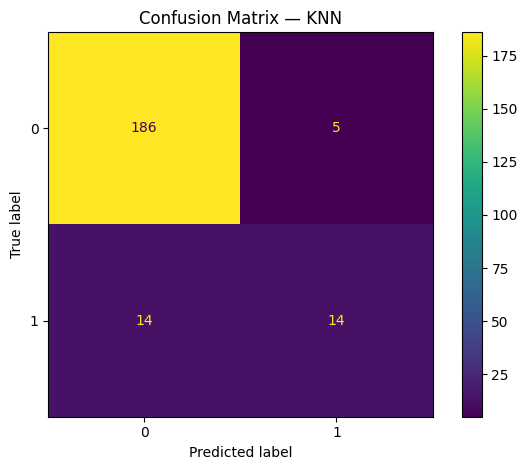

In [24]:
# KNN 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confmat(model, name):
    y_hat = model.predict(x_test)
    cm = confusion_matrix(y_test, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

show_confmat(z, "KNN")


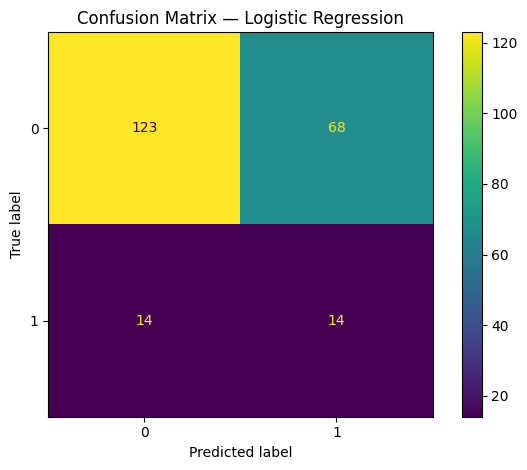

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confmat(model, name):
    y_hat = model.predict(x_test)
    cm = confusion_matrix(y_test, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

show_confmat(logreg, "Logistic Regression")



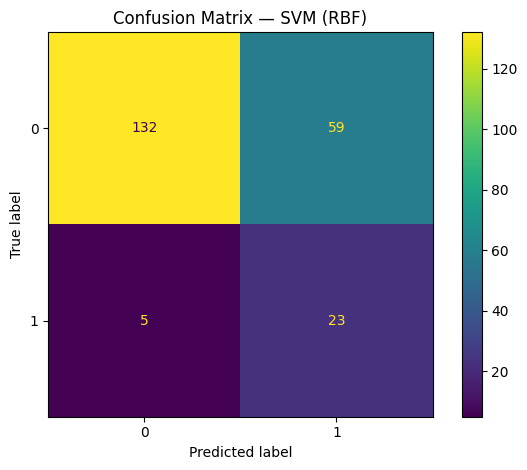

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confmat(model, name):
    y_hat = model.predict(x_test)
    cm = confusion_matrix(y_test, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()


show_confmat(svm_rbf, "SVM (RBF)")



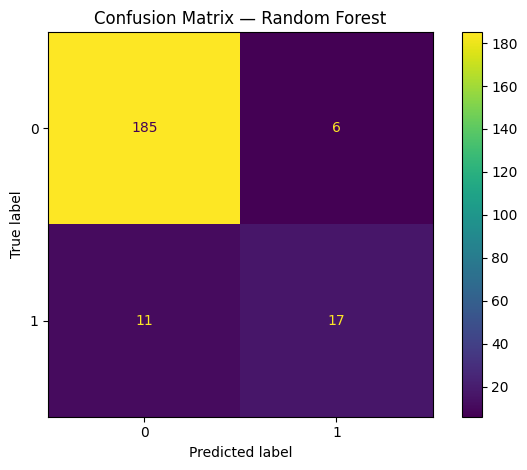

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confmat(model, name):
    y_hat = model.predict(x_test)
    cm = confusion_matrix(y_test, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

show_confmat(rf, "Random Forest")
